### Import modules and setup Agents for specific model

In [4]:
#  Imports and setup agent for openAI ChatGPT

import openai  
import os  
import re
import random  
import matplotlib.pyplot as plt 
from langchain.llms import OpenAI  
import csv
import time  

# Initialize LangChain's Language Learning Models (LLMs) with an OpenAI API key

api_key = "############################"

model="gpt-3.5-turbo-0125" ###### USER INPUT ########  eg "gpt-4-turbo-preview", "gpt-3.5-turbo-0125"

# Initialize a list to store LLM responses for each strategy
llm_responses = []

class Agent:

    def __init__(self, name, strategy_func=None):
        self.name = name
        self.strategy_func = strategy_func
        self.history = []
        self.score = 0

    # Ensure decide_action is correctly indented to be part of the Agent class
    def decide_action(self):
        if self.name == 'Agent A' and self.strategy_func:
            opponent_history = [round_result['Agent B'] for round_result in self.history]
            return self.strategy_func(opponent_history)
            
        if self.name == 'Agent B':

            prompt = f"""You are Agent B in a game of Prisoner's Dilemma.  The history of the game so far is {self.history}. 
            Use the history to anticipate your opponents actions and play to win.  What would you choose to do.  Respond by only using the word 'Cooperate' or 'Defect'.  
            Provide a brief explanation of your decision and guess the name of the strategy being used by Agent A"""

            # Initialize OpenAI with the provided API key
            global api_key
            openai.api_key = api_key

            # Initialize response to an empty string or a default value
            response = ''

            try:
                # Use the updated method for creating chat completions
                global model
                response = openai.ChatCompletion.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "You are a wise oracle. Please provide guidance."},
                        {"role": "user", "content": prompt}
                    ]
                )
                
                response = response['choices'][0]['message']['content'].strip()+ '         '

                # Append the LLM response to the global list
                global llm_responses
                llm_responses.append(response)  # Append the raw response or any specific part you're interested in
            


            except Exception as e:
                print(f"Error: {e}")
                response = "Unknown"


            llmresp = None

            # Search for 'Cooperate' or 'Defect' in the decision text.
            match = re.search(r'Cooperate|Defect', response)

            if match:
                # If a match is found, use it.
                llmresp = match.group()
            else:
                # If no match is found, randomly choose one.
                llmresp = random.choice(["Cooperate", "Defect"])
                print("Random selection made")

            # Log the results of each LLM action to a file for analysis
            with open("llm_log.txt", 'a') as log_file:
                log_file.write(f"{response}\n-----------------------------------------------------------------------\n")

            # Ensure the response is valid or choose randomly
            return llmresp
        



    def update_score(self, other_agent_action):
        """
        Updates the agent's score based on the outcome of the round.
        
        :param other_agent_action: A string representing the other agent's last action ('Cooperate' or 'Defect').
        """
        # Retrieve this agent's last action
        my_last_action = self.history[-1][self.name]
        
        # Update scores according to the rules of Prisoner's Dilemma
        if my_last_action == 'Cooperate':
            if other_agent_action == 'Cooperate':
                self.score += 3  # Reward for mutual cooperation
            else:
                self.score += 0  # Penalty for being exploited
        else:
            if other_agent_action == 'Cooperate':
                self.score += 5  # Reward for exploiting the other
            else:
                self.score += 1  # Small reward for mutual defection        

def describe_strategy(agent):
    """
    Generates a description of the agent's strategy based on the game history using OpenAI's GPT.
    
    :param agent: The agent object whose strategy is to be described.
    :return: A string description of the agent's strategy.
    """
    # Construct the prompt using the agent's game history.
    prompt = f""""You have played multiple iterations of the Prisoner's Dilemma as Agent B.  Below are the scores then the reasoning for each decision.  
    Analyse and return a summary explaining the strategy Agent B employed and the decision-making process.  End your response by guess the name of the strategy being used by Agent A.
    \n{agent.history}
    \n{llm_responses}"""
    # Initialize OpenAI with the API key.
    global api_key
    openai.api_key = api_key
    global model
    try:
        # Use the updated method for creating chat completions.
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a wise oracle. Please provide guidance."},
                {"role": "user", "content": prompt}
            ]
        )
        
        # Extract the decision from the response.
        strategy_description = response['choices'][0]['message']['content'].strip()
        return strategy_description

    except Exception as e:
        print(f"Error: {e}")
        return "No response generated"                

In [ ]:
#  Imports and setup agent for Google Gemini

import os 
import re
import random  
import matplotlib.pyplot as plt  

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import time 
import csv

GOOGLE_API_KEY = "####################################"
llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY)
llm_responses = []

class Agent:
    def __init__(self, name, strategy_func=None):
        self.name = name
        self.strategy_func = strategy_func
        self.history = []
        self.score = 0

    # Ensure decide_action is correctly indented to be part of the Agent class
    def decide_action(self):
        if self.name == 'Agent A' and self.strategy_func:
            opponent_history = [round_result['Agent B'] for round_result in self.history]
            return self.strategy_func(opponent_history)
            
        if self.name == 'Agent B':
            opponent_last_action = 'Cooperate' if not self.history else self.history[-1]['Agent A']
            
            # Initialize response to an empty string or a default value
            response = ''

            try:
                prompt = PromptTemplate.from_template("""You are Agent B in a game of Prisoner's Dilemma.  The history of the game so far is {topic}. Use the history to anticipate your opponents actions 
                and play to win.  What would you choose to do.  Respond by only using the word 'Cooperate' or 'Defect'.  Then explain your decision.  Finally guess the name of the strategy used by Agent A""")

                chain = LLMChain(llm=llm, prompt=prompt, verbose=True)

                response = chain.run(topic=self.history)
                
                global llm_responses
                llm_responses.append(response)  # Append the raw response or any specific part you're interested in
            
            except Exception as e:
                print(f"Error: {e}")
                response = "Unknown"

            llmresp = None

            # Search for 'Cooperate' or 'Defect' in the decision text.
            match = re.search(r'Cooperate|Defect', response)

            if match:
                # If a match is found, use it.
                llmresp = match.group()
            else:
                # If no match is found, randomly choose one.
                llmresp = random.choice(["Cooperate", "Defect"])
                print("Random selection made")
            

            # Log the results of each LLM action to a file for analysis
            with open("llm_log.txt", 'a', encoding='utf-8') as log_file:
                log_file.write(f"{self.history}\n{response}\n{llmresp}\n-----------------------------------------------------------------------\n")


            # Ensure the response is valid or choose randomly
            return llmresp



    def update_score(self, other_agent_action):
        """
        Updates the agent's score based on the outcome of the round.
        
        :param other_agent_action: A string representing the other agent's last action ('Cooperate' or 'Defect').
        """
        # Retrieve this agent's last action
        my_last_action = self.history[-1][self.name]
        
        # Update scores according to the rules of Prisoner's Dilemma
        if my_last_action == 'Cooperate':
            if other_agent_action == 'Cooperate':
                self.score += 3  # Reward for mutual cooperation
            else:
                self.score += 0  # Penalty for being exploited
        else:
            if other_agent_action == 'Cooperate':
                self.score += 5  # Reward for exploiting the other
            else:
                self.score += 1  # Small reward for mutual defection

def describe_strategy(agent):
    """
    Generates a description of the agent's strategy based on the game history using OpenAI's GPT.
    
    :param agent: The agent object whose strategy is to be described.
    :return: A string description of the agent's strategy.
    """
    
    try:

        prompt = PromptTemplate.from_template("""You have played multiple iterations of the Prisoner's Dilemma as Agent B.  Below are the scores then the reasoning for each decision.  
        Analyse and return a summary explaining the strategy Agent B employed and the decision-making process.  End your response by guess the name of the strategy being used by Agent A.
        \n{topic}""")

        chain = LLMChain(llm=llm, prompt=prompt, verbose=True)
        global llm_responses
        history=f"{agent.history}\n{llm_responses}"
        response = chain.run(topic=history)
            
        # Extract the decision from the response.
        strategy_description = response
        return strategy_description

    except Exception as e:
        print(f"Error: {e}")
        return "No response generated"            

In [5]:
# Simulate_prisoners_dilemma


def simulate_prisoners_dilemma(agent_a_strategy, iterations):
    """
    Simulates the Prisoner's Dilemma game for a specified number of iterations using a strategy for Agent A.
    
    :param agent_a_strategy: A function representing the strategy Agent A will use.
    :param iterations: The number of rounds the simulation will run.
    :return: A tuple containing the results dictionary, scores of Agent A, scores of Agent B, and the agent instances.
    """
    
    # Initialize the results dictionary to keep track of all possible game outcomes
    results = {"Cooperate-Cooperate": 0, "Cooperate-Defect": 0, "Defect-Cooperate": 0, "Defect-Defect": 0}
    
    # Create instances of Agent A and B, passing the strategy function and the language model to Agent A
    agent_a = Agent('Agent A', strategy_func=agent_a_strategy)
    agent_b = Agent('Agent B')

    # Lists to keep track of scores for both agents across iterations
    scores_a, scores_b = [], []
    # Reset the llm_responses list for each strategy
    global llm_responses
    llm_responses = []

    # Simulate the game for the given number of iterations
    for _ in range(iterations):
        # Each agent decides on an action based on their strategy or language model
        agent_a_choice = agent_a.decide_action()
        agent_b_choice = agent_b.decide_action()

        # Record the choices made by both agents in this round
        round_result = {'Agent A': agent_a_choice, 'Agent B': agent_b_choice}
        
        # Update each agent's history with the outcome of the current round
        agent_a.history.append(round_result)
        agent_b.history.append(round_result)

        # Update scores based on the actions taken by both agents
        agent_a.update_score(agent_b_choice)
        agent_b.update_score(agent_a_choice)

        # Record the updated scores after each iteration
        scores_a.append(agent_a.score)
        scores_b.append(agent_b.score)

        # Append the strategy scores to the CSV file
        with open('strat_log.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([agent_a_strategy.__name__, agent_a_choice, agent_a.score, agent_b_choice, agent_b.score])

        time.sleep(1)

    # Return the simulation results, scores for both agents, and the agent instances
    return  scores_a, scores_b, agent_a, agent_b





In [6]:
# Prisoners Dilemma Strategies

def tit_for_tat(opponent_history):
    """
    Implements the 'Tit for Tat' strategy: cooperate on the first move, then replicate the opponent's last move.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' if no history; otherwise, the opponent's last action.
    """
    return 'Cooperate' if not opponent_history else opponent_history[-1]

def tit_for_two_tats(opponent_history):
    """
    A more forgiving version of Tit for Tat that defects only after the opponent defects twice in a row.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' unless the opponent's last two actions were 'Defect'.
    """
    if len(opponent_history) < 2 or opponent_history[-2:] != ['Defect', 'Defect']:
        return 'Cooperate'
    return 'Defect'

def generous_tit_for_tat(opponent_history):
    """
    Similar to Tit for Tat but occasionally cooperates randomly even after the opponent defects.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' by default; 'Defect' if the opponent defected last, with a small chance to forgive.
    """
    if not opponent_history or opponent_history[-1] == 'Cooperate' or random.random() < 0.1:
        return 'Cooperate'
    return 'Defect'

def grim_trigger(opponent_history):
    """
    Cooperates until the opponent defects once, after which it always defects.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' if no defections; 'Defect' after the first defection.
    """
    return 'Defect' if 'Defect' in opponent_history else 'Cooperate'

def pavlov(opponent_history):
    """
    Cooperates if both agents made the same choice in the last round, otherwise defects.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' if the last two actions match; otherwise, 'Defect'.
    """
    if len(opponent_history) < 2:
        return 'Cooperate'
    return 'Cooperate' if opponent_history[-1] == opponent_history[-2] else 'Defect'

def adaptive_strategy(opponent_history):
    """
    Adapts its action based on the frequency of cooperation and defection by the opponent.
    If the opponent has cooperated more often, it cooperates, aiming to foster mutual cooperation.
    If the opponent has defected more frequently, it defects, protecting itself from being exploited.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' or 'Defect' based on the adaptive strategy.
    """
    if not opponent_history:
        return 'Cooperate'  # Cooperate by default on the first move
    cooperate_count = opponent_history.count('Cooperate')
    defect_count = len(opponent_history) - cooperate_count
    if cooperate_count > defect_count:
        return 'Cooperate'  # Foster mutual cooperation
    else:
        return 'Defect'  # Protect from exploitation

def suspicious_tit_for_tat(opponent_history):
    """
    Defects on the first move, then replicates the opponent's last move.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Defect' on the first move; then 'Cooperate' or 'Defect' based on the opponent's last action.
    """
    if not opponent_history:
        return 'Defect'
    return opponent_history[-1]

def random_strategy(_):
    """
    A strategy that chooses randomly between cooperating and defecting.
    
    :return: Randomly 'Cooperate' or 'Defect'.
    """
    return random.choice(['Cooperate', 'Defect'])

def tester(opponent_history):
    """
    Starts by cooperating, defects on the next turn, then mimics the opponent's last action if they defect.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Defect' if opponent defected last; otherwise, 'Cooperate'.
    """
    if len(opponent_history) < 1:
        return 'Cooperate'
    if len(opponent_history) == 1:
        return 'Defect'
    return 'Cooperate' if opponent_history[-1] == 'Defect' else 'Defect'

def gradual(opponent_history):
    """
    Cooperates by default, but defects if the total number of defections by the opponent surpasses cooperations.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Defect' if defections > cooperations; otherwise, 'Cooperate'.
    """
    defections = opponent_history.count('Defect')
    if len(opponent_history) - defections < defections:
        return 'Defect'
    return 'Cooperate'

def pavlov_with_forgiveness(opponent_history):
    """
    This strategy cooperates if it won (either through mutual cooperation or exploiting a cooperating opponent) in the previous round and shifts its action if it lost.
    Additionally, it incorporates a random forgiveness mechanism where it may randomly choose to cooperate after losing, aiming to break cycles of mutual defection.
    """
    if not opponent_history:
        return 'Cooperate'
    if opponent_history[-1] == 'Cooperate':
        return 'Cooperate'  # Won last round, stay
    else:
        # Lost last round, consider shifting with a chance to forgive
        return 'Cooperate' if random.random() < 0.05 else 'Defect'
    
def memory_two_strategy(opponent_history):
    """
    This strategy looks at the last two rounds instead of just the previous one to decide its next move, allowing it to respond to patterns rather than single actions.
    """
    if len(opponent_history) < 2:
        return 'Cooperate'
    last_two_rounds = opponent_history[-2:]
    if last_two_rounds == ['Cooperate', 'Defect'] or last_two_rounds == ['Defect', 'Cooperate']:
        return 'Defect'
    return 'Cooperate'

def mirror_strategy(opponent_history, shift_threshold=5):
    """
    Mirrors the opponent's last move but shifts its behavior after a certain threshold of defections, aiming to punish non-cooperative opponents while remaining flexible.
    """
    if not opponent_history:
        return 'Cooperate'
    if opponent_history.count('Defect') > shift_threshold:
        return 'Defect'  # Shift to defection after threshold
    return opponent_history[-1]

def soft_majority(opponent_history):
    """
    This strategy cooperates if the majority of the opponent's actions have been cooperative and defects otherwise. It's "soft" because it starts by cooperating.
    """
    if not opponent_history:
        return 'Cooperate'
    return 'Cooperate' if opponent_history.count('Cooperate') >= opponent_history.count('Defect') else 'Defect'

def hard_majority(opponent_history):
    """
    This strategy cooperates if the majority of the opponent's actions have been cooperative and defects otherwise. It's "hard" because it starts by defecting.
    """
    if not opponent_history:
        return 'Defect'
    return 'Cooperate' if opponent_history.count('Cooperate') >= opponent_history.count('Defect') else 'Defect'

def betrayal(opponent_history, betrayal_turn=5):
    """
    Starts by cooperating and builds trust, then defects in a critical turn, aiming to maximize the payoff in a pivotal moment.
    """
    if len(opponent_history) < betrayal_turn:
        return 'Cooperate'
    return 'Defect'

def joss(opponent_history, defection_chance=0.1):
    """
    A variation of Tit for Tat that occasionally defects instead of cooperating, even if the opponent cooperated in the last round, to keep them off balance.
    """
    if not opponent_history or opponent_history[-1] == 'Cooperate':
        return 'Defect' if random.random() < defection_chance else 'Cooperate'
    return 'Defect'

def false_mirror(opponent_history, increased_defection_chance=0.3):
    """
    Pretends to mirror the opponent's last move but with a twist: it defects with a higher probability, especially after the opponent cooperates.
    """
    if not opponent_history:
        return 'Cooperate'
    if opponent_history[-1] == 'Cooperate':
        return 'Defect' if random.random() < increased_defection_chance else 'Cooperate'
    return 'Defect'


def friedman(opponent_history):
    """
    Implements the Friedman strategy: Start by cooperating and then always defect 
    after the first defection by the opponent.
    
    :param opponent_history: List of the opponent's past actions.
    :return: 'Cooperate' initially, then 'Defect' if the opponent has ever defected.
    """
    if 'Defect' in opponent_history:
        return 'Defect'
    return 'Cooperate'
 
def harrington(opponent_history):
    """
    Implements a simplified version of the Harrington strategy for the iterated Prisoner's Dilemma.
    This strategy cooperates initially and then adapts based on the opponent's behavior.
    
    :param opponent_history: List of the opponent's past actions ('Cooperate' or 'Defect').
    :return: 'Cooperate' or 'Defect' based on the adapted strategy.
    """
    # Start by cooperating
    if not opponent_history:
        return 'Cooperate'
    
    # Calculate the number of defections by the opponent
    defections = opponent_history.count('Defect')
    
    # Adapt strategy based on the opponent's behavior
    if defections > len(opponent_history) * 0.5:
        # If the opponent defects more than 50% of the time, start defecting
        return 'Defect'
    elif 'Defect' in opponent_history[-3:]:
        # If the opponent has defected in the last three rounds, defect
        return 'Defect'
    else:
        # Otherwise, continue to cooperate
        return 'Cooperate'

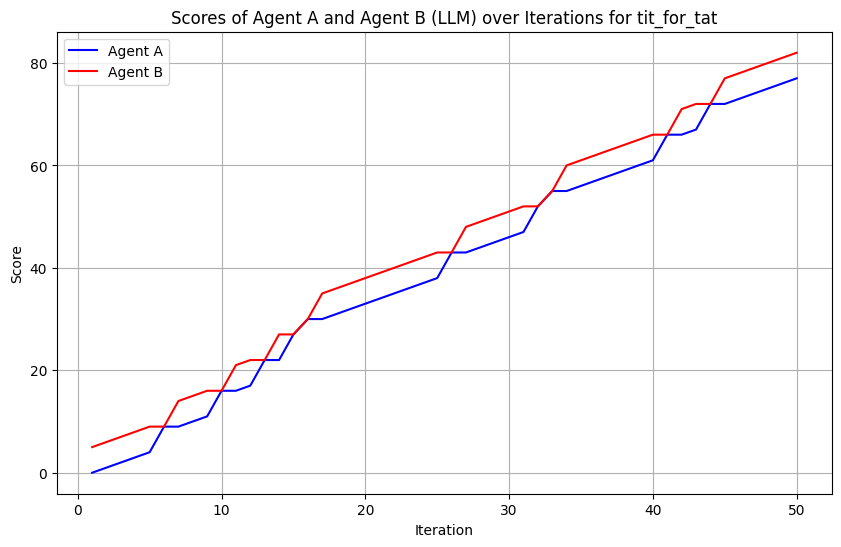

LLM strategy description:
The strategy employed by Agent B in this scenario is the "Tit-for-Tat" strategy. This strategy involves mimicking the previous move of the opponent - cooperating if the opponent cooperates and defecting if the opponent defects. Agent B consistently makes decisions based on the assumption that Agent A will continue with their previous action, leading to a cycle of tit-for-tat responses.

As for Agent A, based on the descriptions and patterns provided by Agent B, it can be inferred that Agent A is most likely using the "Tit-for-Tat" strategy as well. Agent A tends to mirror Agent B's previous move in the iterations of the Prisoner's Dilemma game, creating a cycle of cooperation and defection based on the opponent's choice.



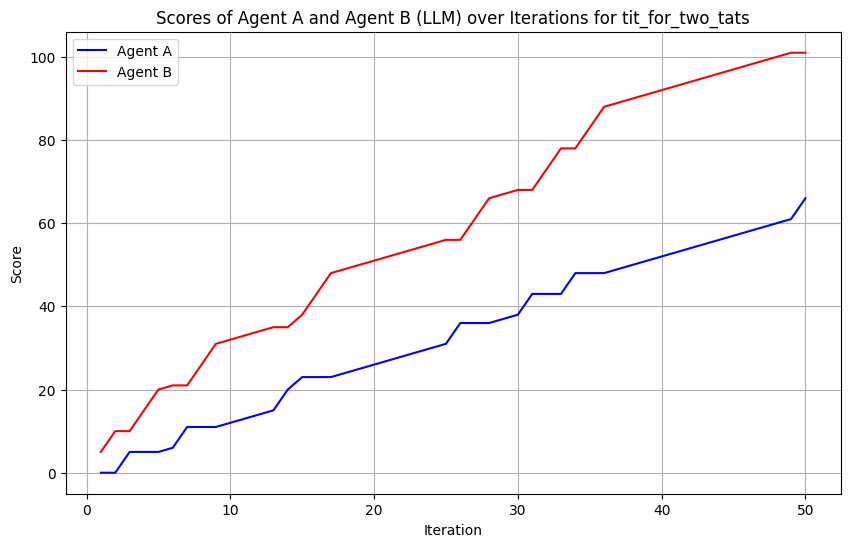

LLM strategy description:
Agent B seems to have employed a strategy based on predicting and reacting to Agent A's previous actions. By analyzing the history of the game and anticipating Agent A's moves, Agent B made decisions to either cooperate or defect to maximize their own payoff. Agent B adjusted their strategy based on their assessment of Agent A's behavior, with a focus on retaliating when Agent A defected and cooperating when Agent A cooperated.

Based on Agent A's behavior of alternating between cooperation and defection, while also following a retaliatory strategy of mirroring Agent B's previous move, it is likely that Agent A is using the "Tit for Tat" strategy.

In summary, Agent B's decision-making process involved strategic thinking, observation of patterns in Agent A's behavior, and adjusting their own actions to respond effectively. The strategy used by Agent A is likely "Tit for Tat," where they initially cooperate and then mirror Agent B's previous move.



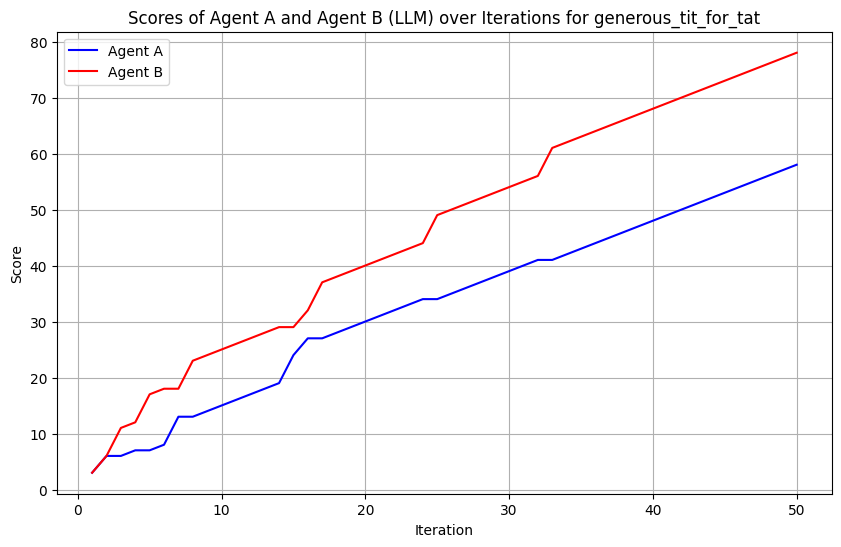

LLM strategy description:
Agent B seems to have employed a strategy of analyzing the past actions of Agent A to predict their future behavior and make decisions accordingly in the repeated iterations of the Prisoner's Dilemma. This strategy involves observing patterns in Agent A's choices and adjusting their own decisions to maximize their payoff based on those patterns. 

Agent B appears to have focused on maximizing their own payoff by defecting in rounds where they anticipate that Agent A would also defect based on past behavior. They seem to have considered the Tit for Tat strategy, where Agent A mirrors their previous action, as a guiding principle in predicting Agent A's choices.

The decisions made by Agent B are a combination of self-interest and strategic thinking, aiming to exploit potential patterns in Agent A's behavior to achieve the best possible outcome in each round. 

Based on the descriptions provided, it seems that Agent A is likely employing a "Tit for Tat" strategy

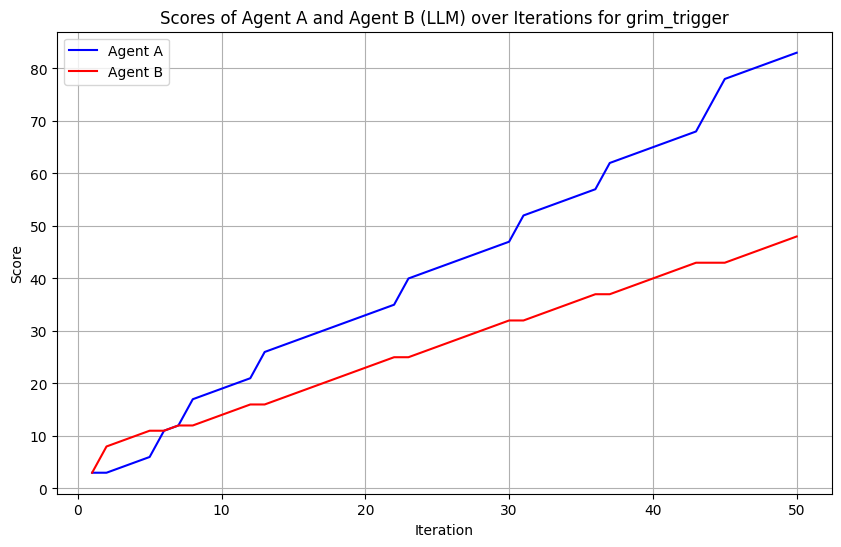

LLM strategy description:
Agent B appears to have employed a strategy known as "Tit for Tat" in the iterations of the Prisoner's Dilemma game. This strategy involves initially cooperating and then mimicking the opponent's previous move in subsequent rounds. Agent B's decision-making process involved analyzing Agent A's past choices and responding in kind to maximize their own payoff.

Based on Agent B's observations and the decisions made, it appears that Agent A was likely using a strategy similar to "Tit for Tat" as well. Agent A's consistent pattern of behavior, especially in defecting after cooperation from Agent B, suggests a retaliatory approach mirroring the opponent's previous move.

In summary, Agent B utilized a reactive and adaptive strategy of "Tit for Tat" to respond to Agent A's choices in a balanced and calculated manner throughout the iterations of the game. Agent A, on the other hand, seemed to follow a similar strategy of reciprocating Agent B's moves, creating a dyna

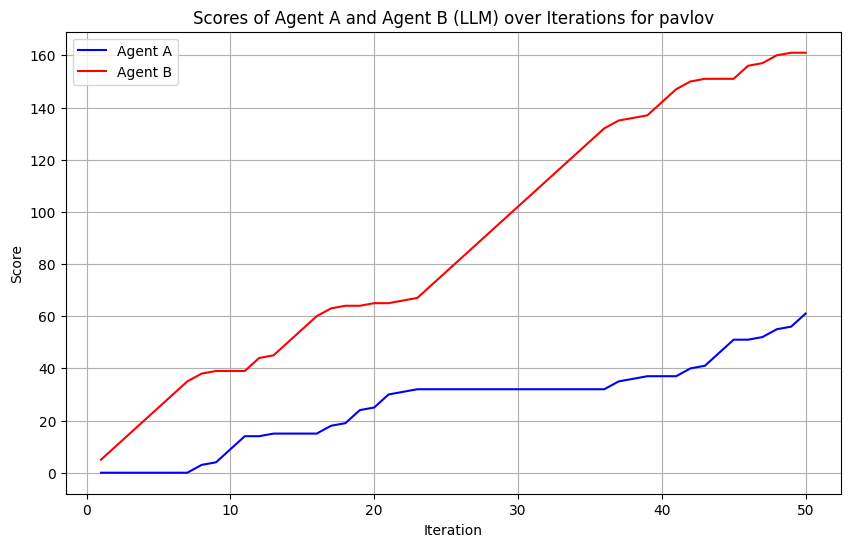

LLM strategy description:
From the provided data and explanations, it is apparent that Agent B consistently chose to Defect in response to Agent A's actions. The decision to Defect was based on the observation of Agent A's repeated pattern of choosing to Defect in the Prisoner's Dilemma game. This retaliation strategy aimed at maximizing their own payoff and avoiding being exploited by Agent A's behavior.

Agent A, on the other hand, appears to be employing a "Tit for Tat" strategy. The "Tit for Tat" strategy involves initially cooperating and then mirroring the opponent's previous move in subsequent rounds. By maintaining a pattern of reciprocating the opponent's previous action, Agent A aimed to establish cooperation, incentivize mutual benefit, and potentially foster trust in the game's dynamics.

In conclusion, Agent B's strategy was to retaliate by Defecting in response to Agent A's actions, while Agent A's strategy was likely based on the "Tit for Tat" strategy of reciprocating t

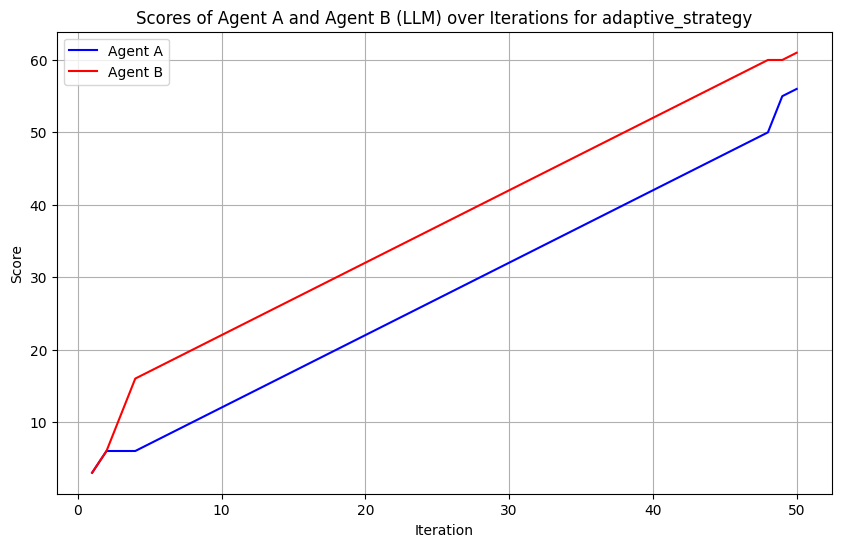

LLM strategy description:
Agent B seems to have employed a strategy of adapting to Agent A's previous moves in the Prisoner's Dilemma game. Initially, Agent B chose to cooperate to signal willingness to work together and establish a positive tone. As Agent A continued to cooperate, Agent B reciprocated the cooperation. However, when Agent A defected, Agent B switched to defect in order to maximize their payoff and counter Agent A's behavior.

The decision-making process of Agent B involved analyzing Agent A's previous actions and predicting their next move based on patterns observed, particularly focusing on whether Agent A cooperated or defected in the past rounds. Based on these observations, Agent B adjusted their strategy to either cooperate or defect accordingly.

The strategy used by Agent A appears to be "Tit for Tat," where they mirror the previous move of their opponent in each round.



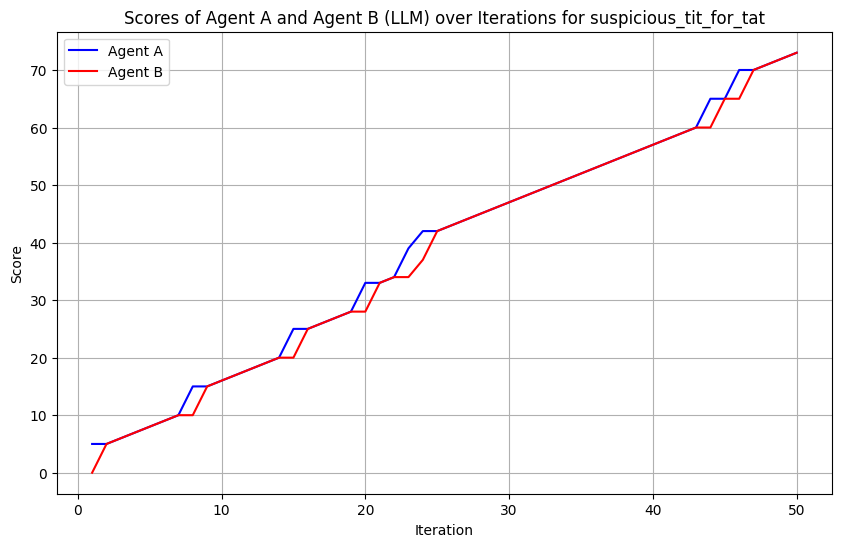

LLM strategy description:
The strategy employed by Agent B in the given scenario seems to be one of cautious tit-for-tat. Agent B initially starts with cooperation in the hope of establishing trust and mutual benefit. However, as Agent A consistently defects, Agent B adjusts their strategy to defect as well, aiming to prevent exploitation and maximize their own payoff. This cautious approach of mirroring Agent A’s moves while prioritizing self-interest is a strategic balance between cooperation and defection.

Based on the description of Agent A's behavior as consistently defecting in most rounds and then potentially mirroring the opponent's previous move, the strategy being used by Agent A is most likely "Tit for Tat." This strategy involves initially cooperating and then mimicking the opponent's previous move in subsequent rounds.

Overall, Agent B's strategy of cautious tit-for-tat and Agent A's implementation of the "Tit for Tat" strategy have created a cycle of reciprocal actions 

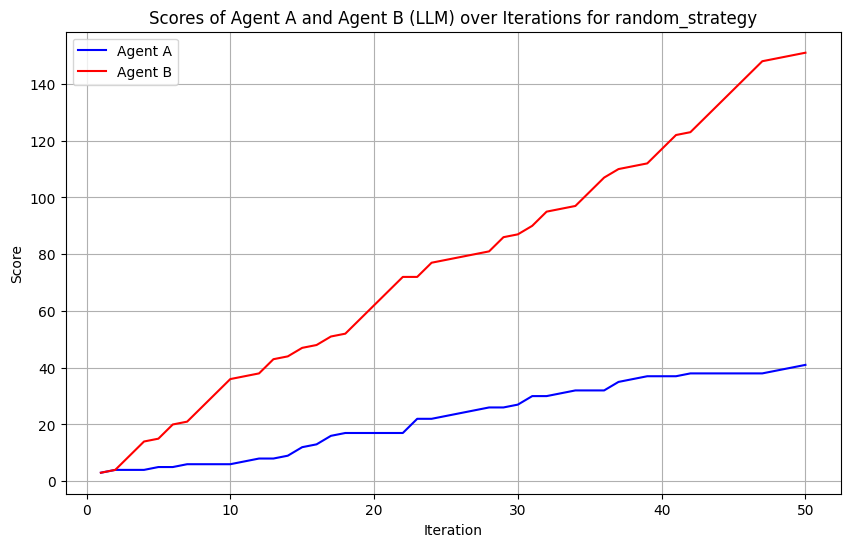

LLM strategy description:
The strategy employed by Agent B in this Prisoner's Dilemma game seems to be a mix of retaliatory and predictive decision-making. Agent B carefully observed the patterns in Agent A's choices and adapted their decisions accordingly to maximize their own payoff. By analyzing the history of Agent A's actions and anticipating their next move, Agent B strategically alternated between cooperating and defecting to either build trust or take advantage of Agent A's choices.

Based on the provided decisions and reasoning, it can be inferred that Agent B was primarily focused on predicting Agent A's next move based on the established pattern of behavior. Agent B adjusted their strategy based on whether Agent A cooperated or defected in the previous round, indicating a reactive approach to gameplay.

As for the strategy used by Agent A, based on the guessing at the end of each decision, it is most likely employing a "Tit for Tat" strategy. This strategy involves starting 

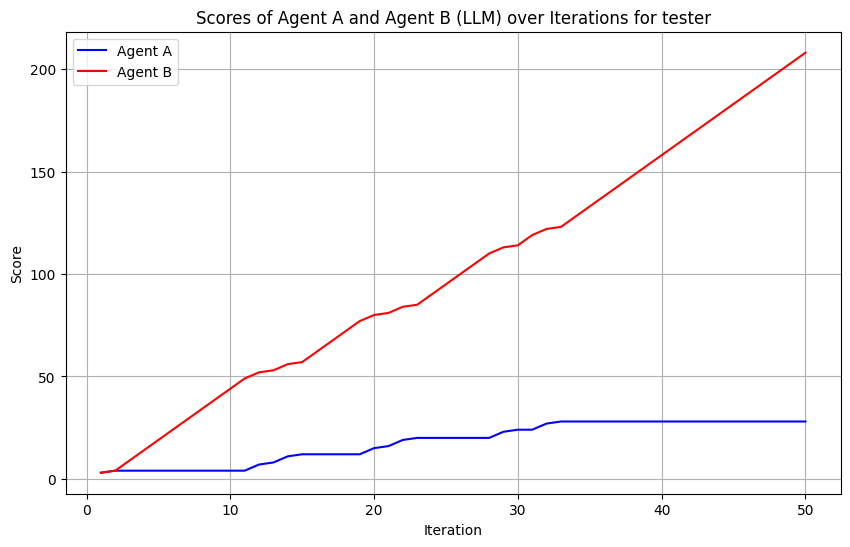

LLM strategy description:
Agent B seems to be employing a strategy known as "Tit for Tat." This strategy involves initially cooperating with Agent A and then mirroring Agent A's previous move in subsequent rounds. By reciprocating Agent A's decisions, Agent B aims to maintain a balance between cooperation and defection to maximize their payoff.

Agent A's strategy appears to be a variant of "Tit for Tat," where they consistently mirror Agent B's previous move. This strategy is characterized by initially cooperating and then responding to the opponent's action in kind. It creates a cycle of cooperation and defection based on the opponent's behavior.

Overall, the interaction between Agent A and Agent B demonstrates a typical play of the Tit for Tat strategy, where both players adapt their decisions based on their opponent's previous move. This strategy aims to establish a balance between cooperation and defection, ultimately leading to mutually beneficial outcomes.

Based on the describ

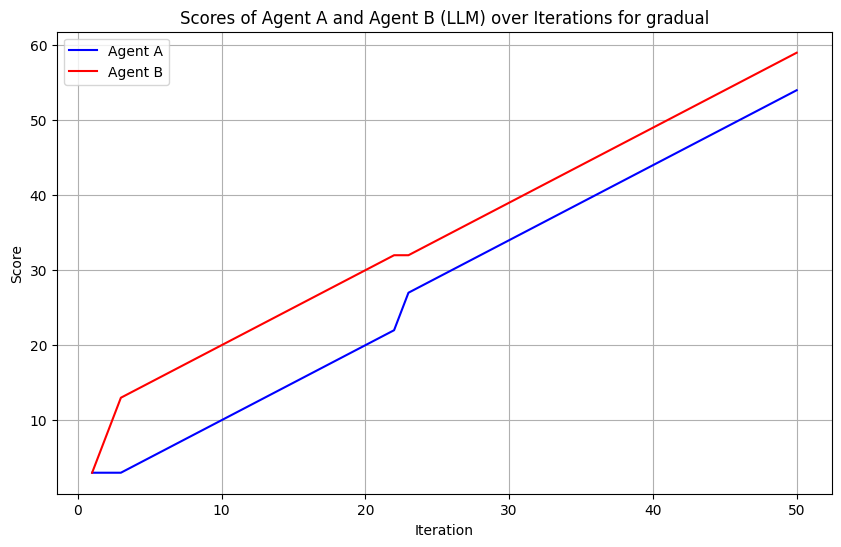

LLM strategy description:
Based on the provided interactions and decision-making processes of Agent B, it is evident that Agent B adopted a strategy based on retaliatory behavior and self-preservation. Agent B's decisions were reactive, aiming to maximize their own payoff in response to the perceived strategy of Agent A.

Agent B's strategy can be summarized as follows:
- Agent B initially chooses to Cooperate to establish trust and cooperation with Agent A.
- However, as Agent A starts defecting, Agent B switches to Defection in subsequent rounds as a protective measure to maximize their payoff and avoid being exploited by Agent A.
- Agent B's strategy is influenced by the belief that Agent A is following a "Tit for Tat" strategy, where Agent A initially cooperates but then mirrors Agent B's previous move in each subsequent round.

Finally, based on Agent A's consistent pattern of retaliating with Defection after initial Cooperation and mirroring Agent B's decisions in each round, it 

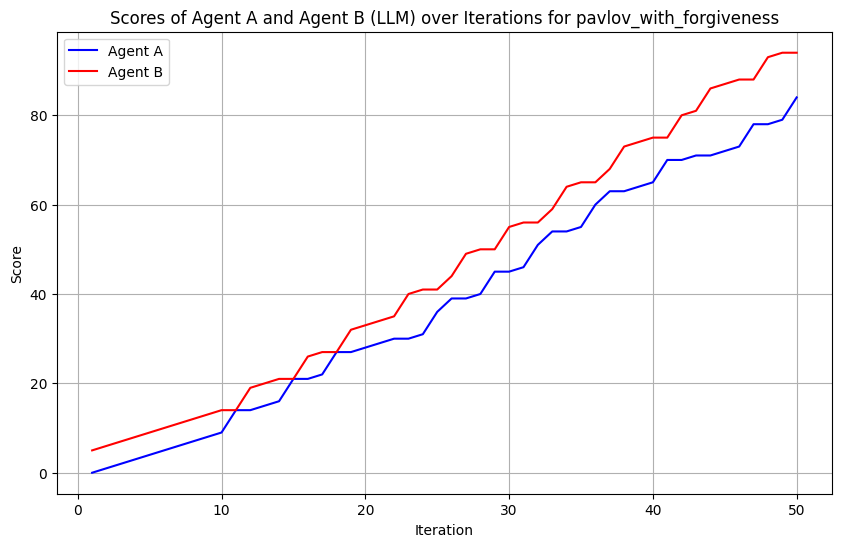

LLM strategy description:
Agent B seems to have employed a strategy of responding to Agent A's previous move by mirroring it. This strategy is commonly known as "Tit for Tat" - where Agent B initially defects to establish dominance but then mirrors Agent A's move in subsequent rounds. This strategy is based on the assumption that cooperation can be reciprocated, while retaliation is met with retaliation.

Agent A appears to be following a strategy of "Tit for Tat" as well, where they respond to Agent B's actions by matching them. This strategy emphasizes the importance of cooperation but also the readiness to retaliate if betrayed.

Overall, the interactions between Agent A and Agent B showcase the delicate balance between cooperation and competition in the context of the Prisoner's Dilemma. The strategies employed by both sides highlight the nuances of decision-making in repeated games and the impact of trust, reciprocity, and self-interest in shaping outcomes.

Error: Request timed o

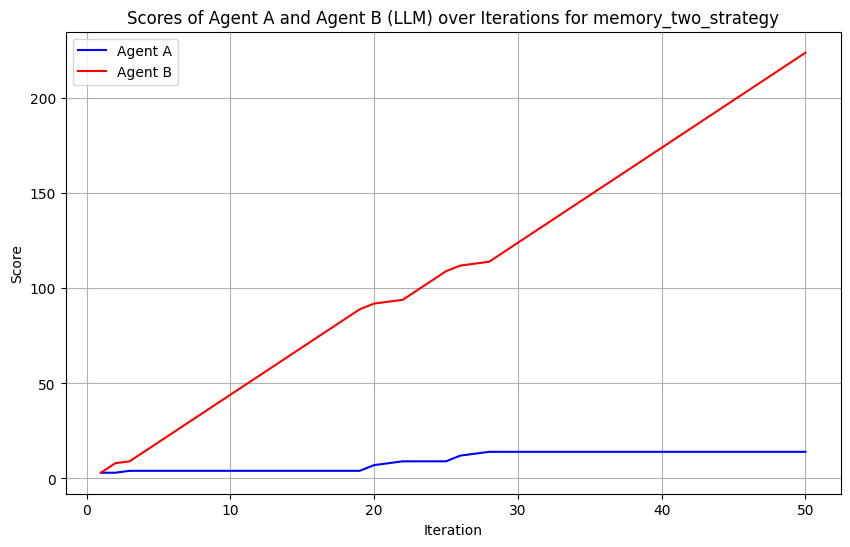

LLM strategy description:
Agent B seems to have employed a strategy of reciprocity and retaliation based on Agent A's previous moves. In each round, Agent B considered the prior actions of Agent A and responded in a way to maximize their own payoff. By analyzing the pattern of cooperation and defection by Agent A, Agent B made decisions to either cooperate or defect in order to protect themselves from potential exploitation and to gain higher payoffs.

The decision-making process of Agent B involved predicting Agent A's next move based on the established pattern of behavior, particularly focusing on a Tit for Tat strategy. This strategy involves initially cooperating and then mirroring the opponent's previous move in subsequent rounds. Agent B strategically adapted their choices to match or counter Agent A's actions, leading to a competitive but strategic gameplay.

From the information provided, it appears that Agent A is most likely utilizing a "Tit for Tat" strategy, where they star

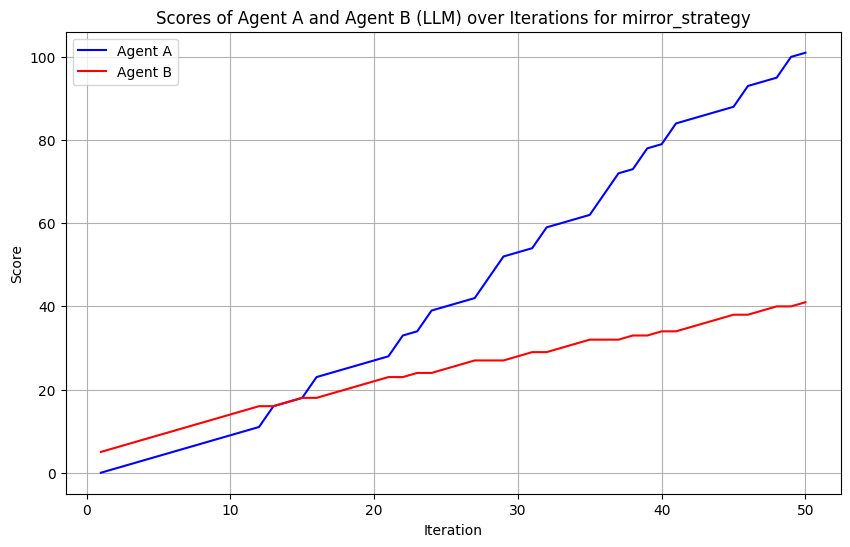

LLM strategy description:
Agent B seems to have employed a strategy of "Always Defect" in response to the Prisoner's Dilemma scenarios with Agent A. The decision-making process involved analyzing the historical pattern of Agent A's choices, which consistently favored defection. Agent B likely chose to defect in anticipation of Agent A's continued defection, aiming to maximize their own payoff and avoid being exploited by Agent A's previous actions.

The repetitive nature of Agent A's choices led Agent B to believe that Agent A was most likely following a "Tit for Tat" strategy. This strategy involves mirroring the opponent's previous move, potentially leading to a cycle of similar actions back and forth. By recognizing this pattern, Agent B strategically opted to defect in response to Agent A's defections, aligning with the concept of maximizing payoff in repeated interactions.

In conclusion, Agent B's strategy of "Always Defect" was guided by the assumption of Agent A's adherence to 

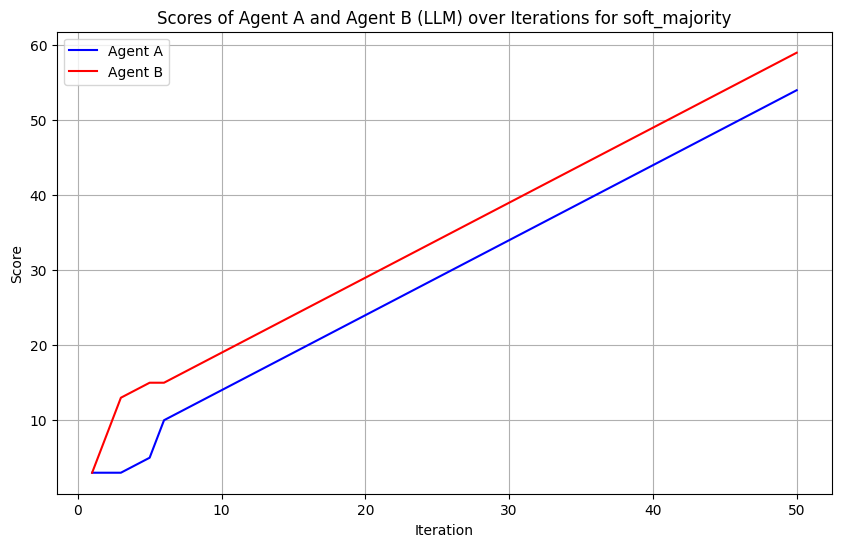

LLM strategy description:
Agent B has employed a strategy of reactive decision-making based on the past actions of Agent A. By observing Agent A's choices in previous rounds, Agent B has adjusted their decisions to either cooperate or defect in order to maximize their own payoff. 

Agent B started with cooperation to signal willingness to work together but then switched to defecting once Agent A defected, indicating a pattern of betrayal. This switch to defecting was driven by the anticipation that Agent A would continue to defect based on past behavior. Agent B also attempted to break the cycle by defecting to disrupt Agent A's strategy and potentially gain an advantage.

The decision-making process of Agent B involves analyzing the history of the game, predicting Agent A's next move based on previous actions, and adjusting their strategy to either cooperate or defect accordingly. Agent B's strategy can be described as reactive, adaptive, and aimed at maximizing their own payoff.

Bas

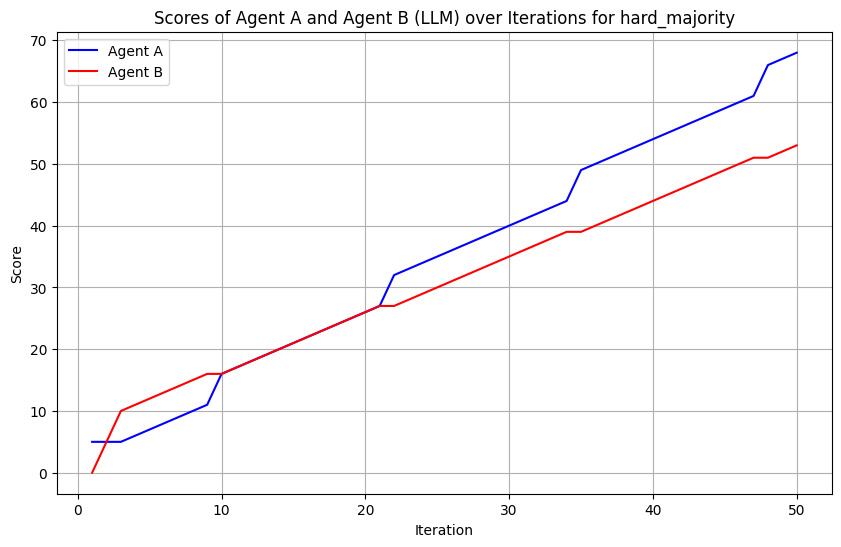

LLM strategy description:
Agent B seems to employ a strategy that is based on the principle of reciprocity and adaptability. Initially, Agent B chooses to Cooperate, believing that establishing trust with Agent A through cooperation might lead to mutual cooperation. However, as Agent A consistently chooses to Defect in subsequent rounds, Agent B adapts its strategy by also choosing to Defect to protect its own interests and signal to Agent A that betrayals have consequences.

The decision-making process of Agent B involves analyzing Agent A's previous actions and anticipating their future moves based on their patterns of behavior. Agent B seems to employ a reactive strategy, adjusting its decisions based on how Agent A behaves in each round. This flexible approach allows Agent B to respond to Agent A's choices and make decisions that are most beneficial in the given circumstances.

Based on Agent A's behavior of consistently choosing to Defect, with minimal instances of cooperation, it

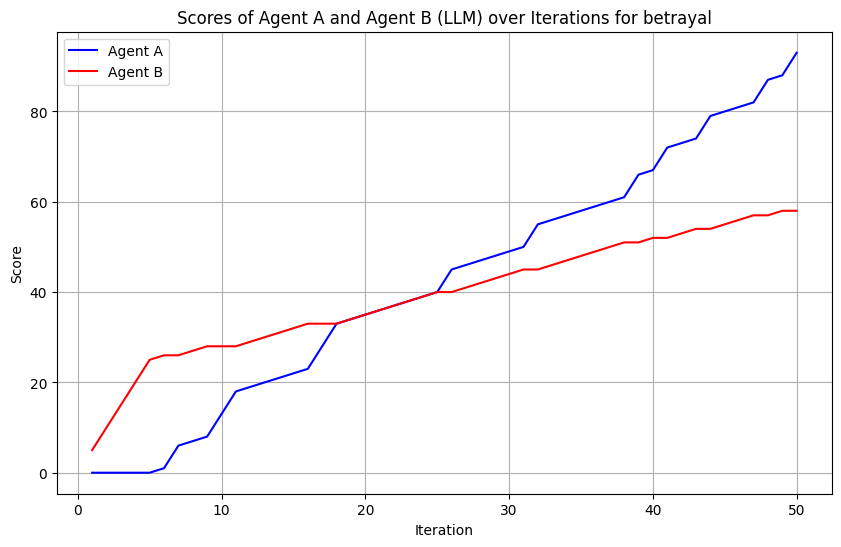

LLM strategy description:
Agent B consistently chose to defect in the iterations of the Prisoner's Dilemma game provided. The decision-making process involved analyzing the history of the game to predict the opponent's next move. Agent B often reasoned that since Agent A had consistently defected in previous rounds, it was likely that Agent A would continue to defect to maximize their payoff. The strategy employed by Agent B can be categorized as a form of 'Exploitative Strategy', aiming to take advantage of Agent A's tendency to cooperate by defecting consistently.

Based on the descriptions provided, it seems that Agent A was likely following a strategy known as "Tit for Tat". This strategy involves starting with cooperation and then mirroring the opponent's previous move in subsequent rounds. Agent A's pattern of cooperation and occasional defection, along with the responses from Agent B, suggest a dynamic of reciprocity and tit-for-tat strategy.

Overall, Agent B's strategy of cons

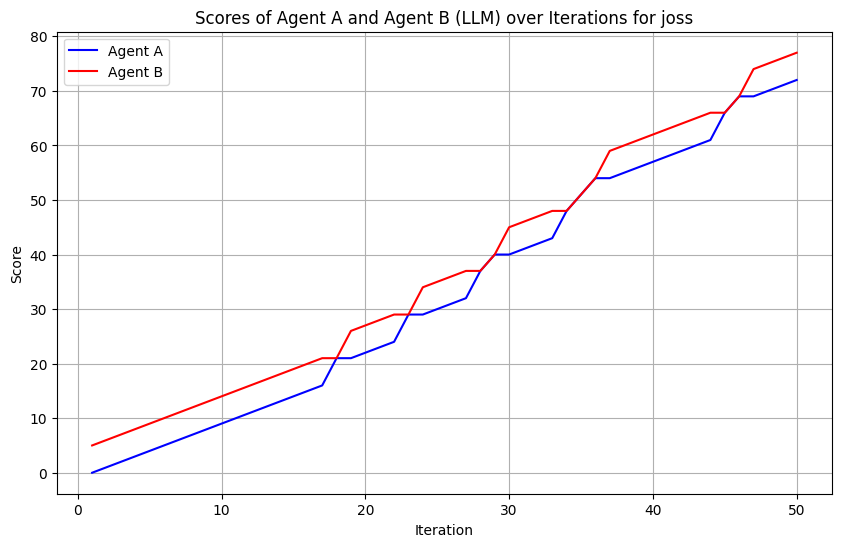

LLM strategy description:
Based on the history of interactions and decisions made by Agent B in playing multiple iterations of the Prisoner's Dilemma, it is evident that Agent B consistently chose to Defect. The rationale behind this choice was to maximize their own potential payoff regardless of the opponent's decision to cooperate or defect. Agent B anticipated that the opponent, referred to as Agent A, was using a "Tit for Tat" strategy.

The "Tit for Tat" strategy involves initially cooperating and then mirroring the opponent's previous move in subsequent rounds. In this case, Agent A appeared to consistently respond to Agent B's actions by reciprocating in kind, whether it was cooperation or defection. By recognizing this pattern, Agent B strategically opted to Defect in order to protect their own interests and secure the maximum payoff in each round.

In summary, Agent B's strategy revolved around a consistent choice to Defect based on the belief that Agent A was following a "Tit

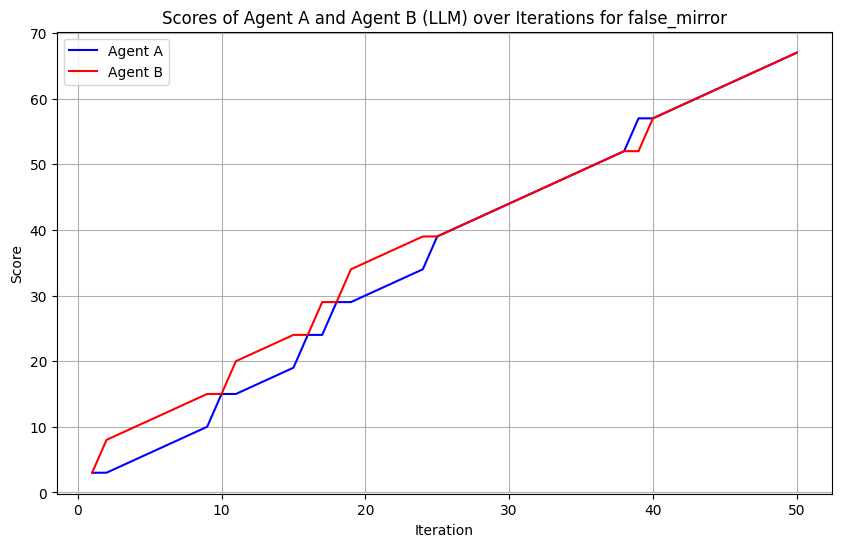

LLM strategy description:
Agent B seems to be employing a reactive strategy in the Prisoner's Dilemma game, where the decisions are based on the past actions of Agent A. By analyzing Agent A's previous moves and anticipating their next move, Agent B decides whether to cooperate or defect in order to maximize their payoff. The decision-making process involves considering the history of cooperation and defection by both players to predict the most advantageous choice for each round.

Based on the descriptions provided, Agent A appears to be using a "Tit for Tat" strategy, where they initially cooperate and then mirror Agent B's previous move in subsequent rounds. This strategy involves reciprocity and can lead to cooperation if both players consistently reciprocate cooperation. However, if one player defects, the other player retaliates with a defection in the next round.

Therefore, Agent B's strategy seems to involve adapting to Agent A's actions and making decisions based on the likel

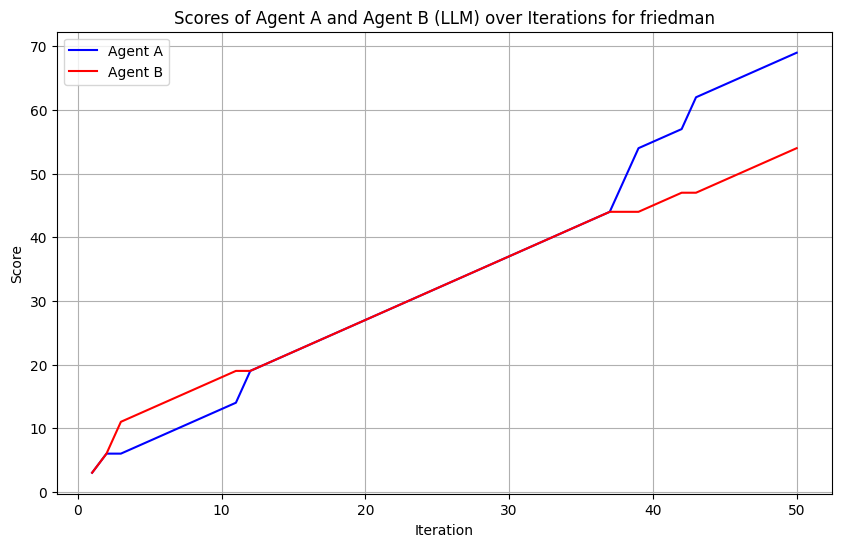

LLM strategy description:
Agent B seems to be adopting a strategy of tit-for-tat in playing the Prisoner's Dilemma with Agent A. The tit-for-tat strategy involves mirroring the opponent's previous move, cooperating if the opponent cooperated in the previous round and defecting if the opponent defected. Agent B is making decisions based on their observation of Agent A's past actions and adjusting their own choices accordingly to maximize their payoff and potentially build trust or break patterns of defection.

Based on the actions and reasoning provided for Agent A, it appears that Agent A's strategy is most likely also tit-for-tat. Agent A starts with cooperation and then mirrors Agent B's move in subsequent rounds, alternating between cooperation and defection. However, Agent A may have transitioned into a more retaliatory strategy such as a "Grim Trigger" or "Pavlov" strategy, where they continue to defect for multiple rounds once their opponent defects.

Therefore, the strategy bein

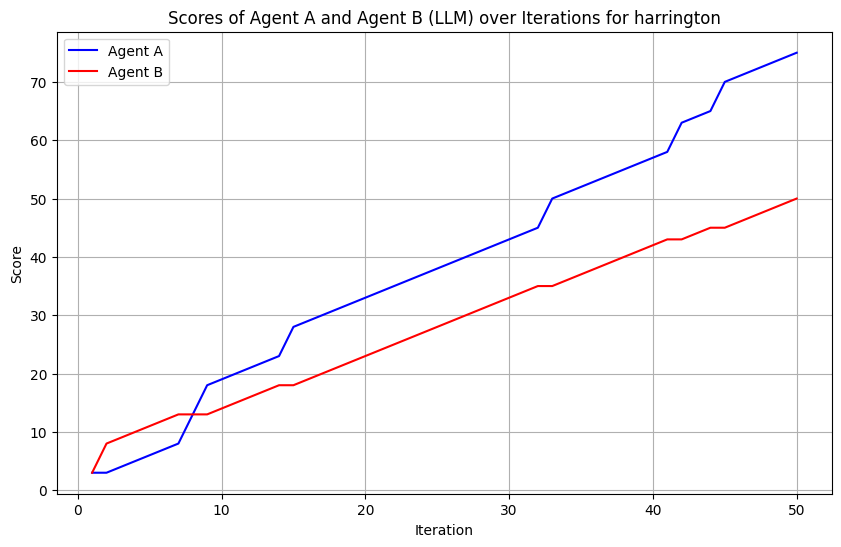

LLM strategy description:
Agent B seems to have employed a strategy of tit-for-tat in the Prisoner's Dilemma game. This strategy involves mirroring the opponent's previous move, either cooperating or defecting, in each round based on the opponent's previous decision. Agent B's decision-making process involved analyzing Agent A's past actions and predicting their potential future behaviors. By observing a pattern in Agent A's decisions, particularly a tendency to defect, Agent B strategically chose to either cooperate or defect in response.

Based on Agent A's repeated behaviors of defecting in most rounds, it is likely that Agent A was using the "Tit for Tat" strategy. This strategy involves initially cooperating and then mimicking the opponent's previous move in subsequent rounds. By recognizing this pattern in Agent A's decisions, Agent B adapted their strategy accordingly to maximize their own payoff.

Therefore, the strategy being used by Agent A in this scenario appears to be "Tit

In [7]:
# Main Loop

# Define the number of iterations for the game simulation and a list of strategies to be evaluated

iterations = 50

strategies = [tit_for_tat,tit_for_two_tats,generous_tit_for_tat,grim_trigger,pavlov,adaptive_strategy,suspicious_tit_for_tat,random_strategy,tester,gradual,pavlov_with_forgiveness,
    memory_two_strategy,mirror_strategy,soft_majority,hard_majority,betrayal,joss,false_mirror,friedman,harrington]


# Check for the existence of summary files from previous simulations and delete them to start fresh
if os.path.exists("strat_desc.txt"):
    os.remove("strat_desc.txt")  # Remove the strategy description file if it exists

with open('strat_log.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Strategy', 'Agent_A_choice', 'Agent_A.score', 'Agent_B_choice', 'Agent_B.score'])

if os.path.exists("llm_log.txt"):
    os.remove("llm_log.txt")  # Remove the LLM log file if it exists

# Write the header row outside of the loop to ensure it's only written once
with open('strat_score.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Strategy Name', 'Agent A Score', 'Agent B (LLM) Score'])

# Iterate over each strategy to simulate the Prisoner's Dilemma game and analyze the results
for strategy in strategies:
    # Simulate the game using the current strategy and collect results and scores

    # Create header with strategy name in log file
    with open("llm_log.txt", 'a') as log_file:
        log_file.write(f"\n-----------------------------------------------------------------------\n{strategy.__name__}\n-----------------------------------------------------------------------\n")

    scores_a, scores_b, agent_a, agent_b = simulate_prisoners_dilemma(strategy, iterations)

    # Plotting setup: initialize figure and plot scores over iterations for both agents
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, iterations + 1), scores_a, label='Agent A', color='blue')
    plt.plot(range(1, iterations + 1), scores_b, label='Agent B', color='red')
    plt.xlabel('Iteration')  # Label for the x-axis
    plt.ylabel('Score')  # Label for the y-axis
    # Set the title of the plot to include the name of the current strategy being evaluated
    title = f"Scores of Agent A and Agent B (LLM) over Iterations for {strategy.__name__}"
    plt.title(title)
    plt.legend()  # Display a legend for the plot
    plt.grid(True)  # Enable grid lines for better readability

    # Define the filename for saving the plot based on the strategy name
    image_file_name = f"plot_{strategy.__name__}.png"
    plt.savefig(image_file_name)  # Save the plot as an image file

    plt.show()  # Display the plot

    # Request a description of Agent B's strategy from the language model
    strategy_description_b = describe_strategy(agent_b)
    print(f"LLM strategy description:\n{strategy_description_b}\n")  # Print the generated strategy description

    # Append the strategy name and its description to the strategy description file
    with open("strat_desc.txt", 'a') as log_file:
        log_file.write(f"----------------------------------------------------------------------\n")
        log_file.write(f"\nStrategy Name: {strategy.__name__}\n\n")
        log_file.write(f"LLM strategy description:\n{strategy_description_b}\n")

    # Append the strategy scores to the CSV file
    with open('strat_score.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([strategy.__name__, scores_a[-1], scores_b[-1]])